### Importing libraries and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
# Loading data 
company = 'AAPL'
start_date = '2020-01-01'
end_date = '2024-01-01'

data = yf.download(company, start=start_date, end=end_date)

prices = data['Close'].values.reshape(-1, 1)

print(f"Data loaded: {len(prices)} days of stock prices.")


C:\Users\HUMAIDU\AppData\Local\Temp\ipykernel_139836\3208946979.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(company, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Data loaded: 1006 days of stock prices.


### Data preprocessing

In [3]:
# Scaling the data to (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(prices)

#Define Training Data (80% of data)
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]

# Creating X_train and y_train sequences 
# use a "look back" of 60 days to predict the 61st day
X_train = []
y_train = []
prediction_days = 60

for i in range(prediction_days, len(train_data)):
    X_train.append(train_data[i-prediction_days:i, 0]) # Days 0-59
    y_train.append(train_data[i, 0])

# Convert to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape for LSTM: (Samples, Time Steps, Features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(f"Training data prepared: {X_train.shape} samples, each with {X_train.shape[1]} time steps.")


Training data prepared: (744, 60, 1) samples, each with 60 time steps.


### Building and Training of LSTM model

We use return_sequences=True in the first LSTM layer to pass the sequence to the second LSTM layer. The second one has False because it feeds into a dense layer.

In [4]:
model = Sequential()

#first LSTM layer with Dropout regularisation
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2)) # prevent overfitting

#Second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

#Output layer
model.add(Dense(units=1)) # predict the next closing price

#compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Training the model
model.fit(X_train, y_train, batch_size=32, epochs=25)

c:\Users\HUMAIDU\anaconda3\envs\mlpython310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0595
Epoch 2/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0073
Epoch 3/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0052
Epoch 4/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0044
Epoch 5/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0045
Epoch 6/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0045
Epoch 7/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0043
Epoch 8/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0046
Epoch 9/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0041
Epoch 10/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0042
Epoch 11/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0041
Epoch 12/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0038
Epoch 13/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0044
Epoch 14/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0038
Epoch 15/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0042
Epoc

#### Testing and Prediction

This is the tricky part. To predict the first day of the Test Set, we need the last 60 days of the Training Set. 

In [5]:
# Creating the testing dataset
# get the unscale data for the test period
test_data = scaled_data[training_data_len - prediction_days:, :]

X_test = []
y_test = prices[training_data_len:, :]  # actual prices for comparison

for i in range(prediction_days, len(test_data)):
    X_test.append(test_data[i-prediction_days:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Getting the model's predicted price values
predictions = model.predict(X_test)

# Inverse transform to get actual prices
predictions = scaler.inverse_transform(predictions)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


#### Visualization 

C:\Users\HUMAIDU\AppData\Local\Temp\ipykernel_139836\1734572485.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


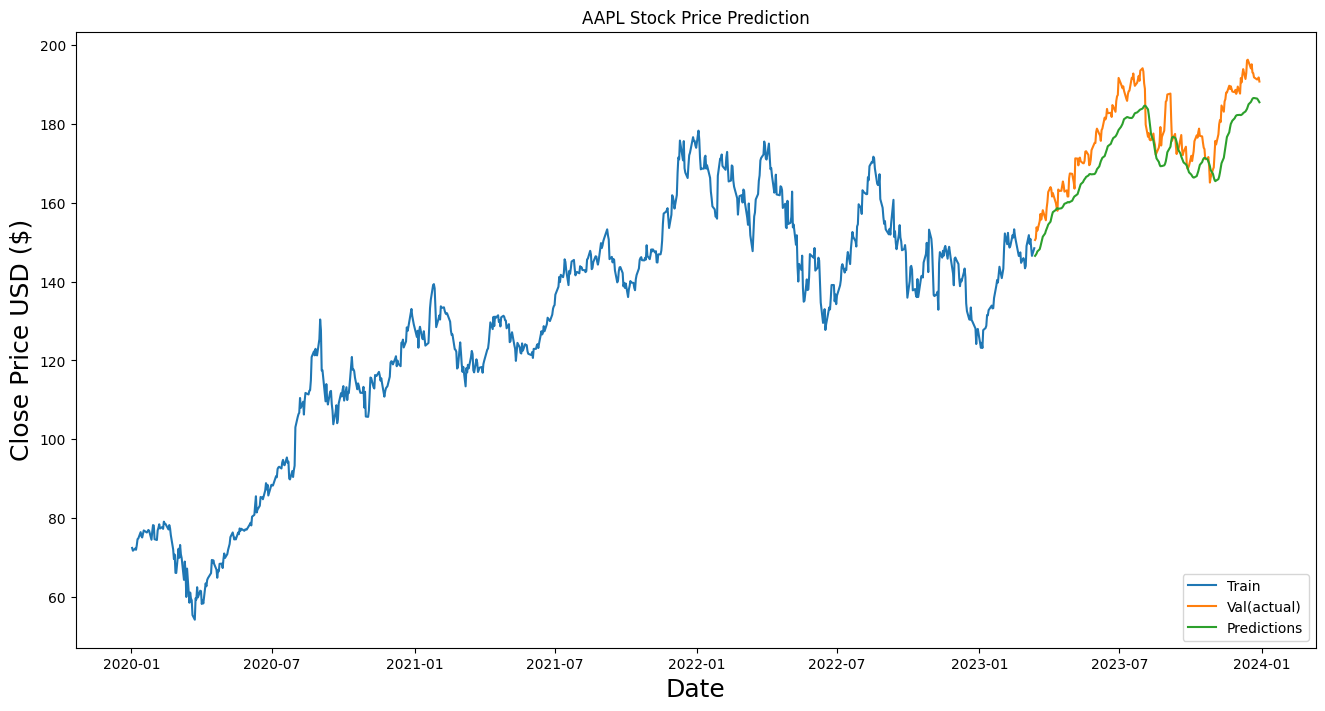

In [8]:
plt.figure(figsize=(16, 8))
plt.title(f"{company} Stock Price Prediction")
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)

# split data for plotting
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# plotting
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val(actual)', 'Predictions'], loc='lower right') 
plt.show()